In [1]:
# Importation des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
import argparse

# Données
import wrds

In [2]:
# Enlever tous les messages de prévention sous les résultats 
import warnings
warnings.filterwarnings('ignore')

## Préparation des données DEVISES

In [3]:
currencies = pd.read_csv('currencies.csv')
currencies['date'] = pd.to_datetime(currencies['date'])

currencies

,date,dexalus,dexcaus,dexjpus,dexszus,dexukus
0,2005-01-03,1.283697,1.2108,102.83,1.1466,0.524714
1,2005-01-04,1.304121,1.2248,104.27,1.1674,0.530955
2,2005-01-05,1.302423,1.2236,103.95,1.1673,0.529801
3,2005-01-06,1.313715,1.2371,104.87,1.1733,0.533305
4,2005-01-07,1.319261,1.2333,104.93,1.1859,0.534702
...,...,...,...,...,...,...
5212,2024-12-25,NaN,NaN,NaN,NaN,NaN
5213,2024-12-26,1.605910,1.4404,158.01,0.9000,0.798594
5214,2024-12-27,1.610825,1.4433,157.73,0.9018,0.795355
5215,2024-12-30,1.607976,1.4374,157.26,0.9066,0.798531


In [4]:
# Renommer colonnes
currencies.columns = ['date', 'Australia', 'Canada', 'Japan', 'Switzerland', 'UK']
currencies

,date,Australia,Canada,Japan,Switzerland,UK
0,2005-01-03,1.283697,1.2108,102.83,1.1466,0.524714
1,2005-01-04,1.304121,1.2248,104.27,1.1674,0.530955
2,2005-01-05,1.302423,1.2236,103.95,1.1673,0.529801
3,2005-01-06,1.313715,1.2371,104.87,1.1733,0.533305
4,2005-01-07,1.319261,1.2333,104.93,1.1859,0.534702
...,...,...,...,...,...,...
5212,2024-12-25,NaN,NaN,NaN,NaN,NaN
5213,2024-12-26,1.605910,1.4404,158.01,0.9000,0.798594
5214,2024-12-27,1.610825,1.4433,157.73,0.9018,0.795355
5215,2024-12-30,1.607976,1.4374,157.26,0.9066,0.798531


In [5]:
# Nettoyage + fréquence données 

currencies_daily = currencies.dropna()

print(f"Nombre observations avant nettoyage : {len(currencies)}")
print(f"Nombre observations après nettoyage : {len(currencies_daily)}")
print(f"Nombre observations supprimées : {len(currencies) - len(currencies_daily)}")

print(f"\nDate de début : {currencies_daily['date'].min()}")
print(f"Date de fin : {currencies_daily['date'].max()}\n")
print(f"Durée totale : {(currencies_daily['date'].max() - currencies_daily['date'].min()).days} jours\n")

currencies_daily.info()

Nombre observations avant nettoyage : 5217
Nombre observations après nettoyage : 5011
Nombre observations supprimées : 206

Date de début : 2005-01-03 00:00:00
Date de fin : 2024-12-31 00:00:00

Durée totale : 7302 jours

<class 'pandas.core.frame.DataFrame'>
Index: 5011 entries, 0 to 5216
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5011 non-null   datetime64[ns]
 1   Australia    5011 non-null   float64       
 2   Canada       5011 non-null   float64       
 3   Japan        5011 non-null   float64       
 4   Switzerland  5011 non-null   float64       
 5   UK           5011 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 274.0 KB


In [6]:
currencies_daily

,date,Australia,Canada,Japan,Switzerland,UK
0,2005-01-03,1.283697,1.2108,102.83,1.1466,0.524714
1,2005-01-04,1.304121,1.2248,104.27,1.1674,0.530955
2,2005-01-05,1.302423,1.2236,103.95,1.1673,0.529801
3,2005-01-06,1.313715,1.2371,104.87,1.1733,0.533305
4,2005-01-07,1.319261,1.2333,104.93,1.1859,0.534702
...,...,...,...,...,...,...
5211,2024-12-24,1.605136,1.4383,157.29,0.9009,0.798212
5213,2024-12-26,1.605910,1.4404,158.01,0.9000,0.798594
5214,2024-12-27,1.610825,1.4433,157.73,0.9018,0.795355
5215,2024-12-30,1.607976,1.4374,157.26,0.9066,0.798531


### Justification du choix des données

**Pays d'origine** : USD (États-Unis)
- Toutes les paires de devises utilisent le dollar américain comme monnaie d'origine
- Ceci permet une analyse cohérente et facilite la comparaison entre devises

**Choix des 5 devises** :
1. **Brazil (BRL)** : Économie émergente d'Amérique du Sud, fortement influencée par les matières premières
2. **Canada (CAD)** : Économie développée, fortement liée aux États-Unis (commerce ALENA/ACEUM)
3. **Mexico (MXN)** : Économie émergente, également intégrée dans l'ACEUM
4. **UK (GBP)** : Économie européenne majeure, centre financier important (Brexit après 2016)
5. **EU (EUR)** : Zone euro, représentant la 2e plus grande économie mondiale

**Justification de la période** :
- Les données couvrent une période longue permettant de capturer différents cycles économiques
- Période suffisante pour analyser les relations macroéconomiques à basse fréquence
- Inclut des événements majeurs : crise de 2008, crise dette européenne, Brexit, COVID-19

**Fréquence** : 
- Les données brutes sont quotidiennes (jours ouvrables)
- Pour l'analyse factorielle, nous convertirons en fréquence **mensuelle** pour correspondre à la disponibilité des données macroéconomiques (PIB, inflation, taux d'intérêt, etc.)

## Conversion en fréquence mensuelle

In [7]:
# Recharger les données nettoyées pour éviter les problèmes de réexécution
currencies_temp = currencies.dropna().copy()

# Supprimer la colonne year temporaire si elle existe
if 'year' in currencies_temp.columns:
    currencies_temp = currencies_temp.drop('year', axis=1)

# Définir la date comme index
currencies_temp = currencies_temp.set_index('date')

# Rééchantillonner à fréquence mensuelle (dernier jour du mois)
currencies_monthly = currencies_temp.resample('ME').last()

# Supprimer les valeurs manquantes qui pourraient être créées
currencies_monthly = currencies_monthly.dropna()

print(f"Observations quotidiennes : {len(currencies_temp)}")
print(f"Observations mensuelles : {len(currencies_monthly)}")
print(f"Période : {currencies_monthly.index.min()} à {currencies_monthly.index.max()}")
print(f"Nombre d'années : {(currencies_monthly.index.max() - currencies_monthly.index.min()).days / 365.25:.1f}")

currencies_monthly.info()

Observations quotidiennes : 5011
Observations mensuelles : 240
Période : 2005-01-31 00:00:00 à 2024-12-31 00:00:00
Nombre d'années : 19.9
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2005-01-31 to 2024-12-31
Freq: ME
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Australia    240 non-null    float64
 1   Canada       240 non-null    float64
 2   Japan        240 non-null    float64
 3   Switzerland  240 non-null    float64
 4   UK           240 non-null    float64
dtypes: float64(5)
memory usage: 11.2 KB


## Calcul des rendements logarithmiques

Les rendements logarithmiques sont préférés pour l'analyse car :
- Ils sont additifs dans le temps
- Ils ont de meilleures propriétés statistiques
- Ils sont symétriques pour les hausses et baisses
- Formule : $r_t = \ln(S_t / S_{t-1}) = \ln(S_t) - \ln(S_{t-1})$

In [8]:
# Calculer les rendements logarithmiques mensuels
returns = np.log(currencies_monthly / currencies_monthly.shift(1))

returns = returns.dropna()

# Convertir l'index en colonne pour faciliter les futures fusions
returns = returns.reset_index().rename(columns={'index': 'date'})

print(f"Nombre d'observations de rendements : {len(returns)}")
print(f"\nStatistiques descriptives des rendements mensuels :")
print(returns[['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']].describe())

Nombre d'observations de rendements : 239

Statistiques descriptives des rendements mensuels :
        Australia      Canada       Japan  Switzerland          UK
count  239.000000  239.000000  239.000000   239.000000  239.000000
mean     0.000949    0.000627    0.001751    -0.001129    0.001712
std      0.035571    0.025482    0.027461     0.027786    0.025619
min     -0.088366   -0.085832   -0.075052    -0.130846   -0.087979
25%     -0.022536   -0.014970   -0.014262    -0.017888   -0.016751
50%      0.001297   -0.000443   -0.000246    -0.001204    0.001303
75%      0.021490    0.015222    0.019080     0.016745    0.016485
max      0.184246    0.137416    0.084550     0.118363    0.096575


In [9]:
returns

,date,Australia,Canada,Japan,Switzerland,UK
0,2005-02-28,-0.023060,-0.008181,0.006737,-0.024893,-0.020946
1,2005-03-31,0.026934,-0.016483,0.028091,0.031187,0.018932
2,2005-04-30,-0.013494,0.038444,-0.024357,-0.004528,-0.012313
3,2005-05-31,0.031510,-0.004466,0.031328,0.045109,0.047716
4,2005-06-30,-0.003551,-0.020673,0.026866,0.030073,0.016648
...,...,...,...,...,...,...
234,2024-08-31,-0.034590,-0.022932,-0.029901,-0.035168,-0.022487
235,2024-09-30,-0.024675,0.001333,-0.018673,-0.005786,-0.020128
236,2024-10-31,0.056972,0.031186,0.061589,0.023872,0.041369
237,2024-11-30,0.005665,0.005366,-0.012816,0.019921,0.012287


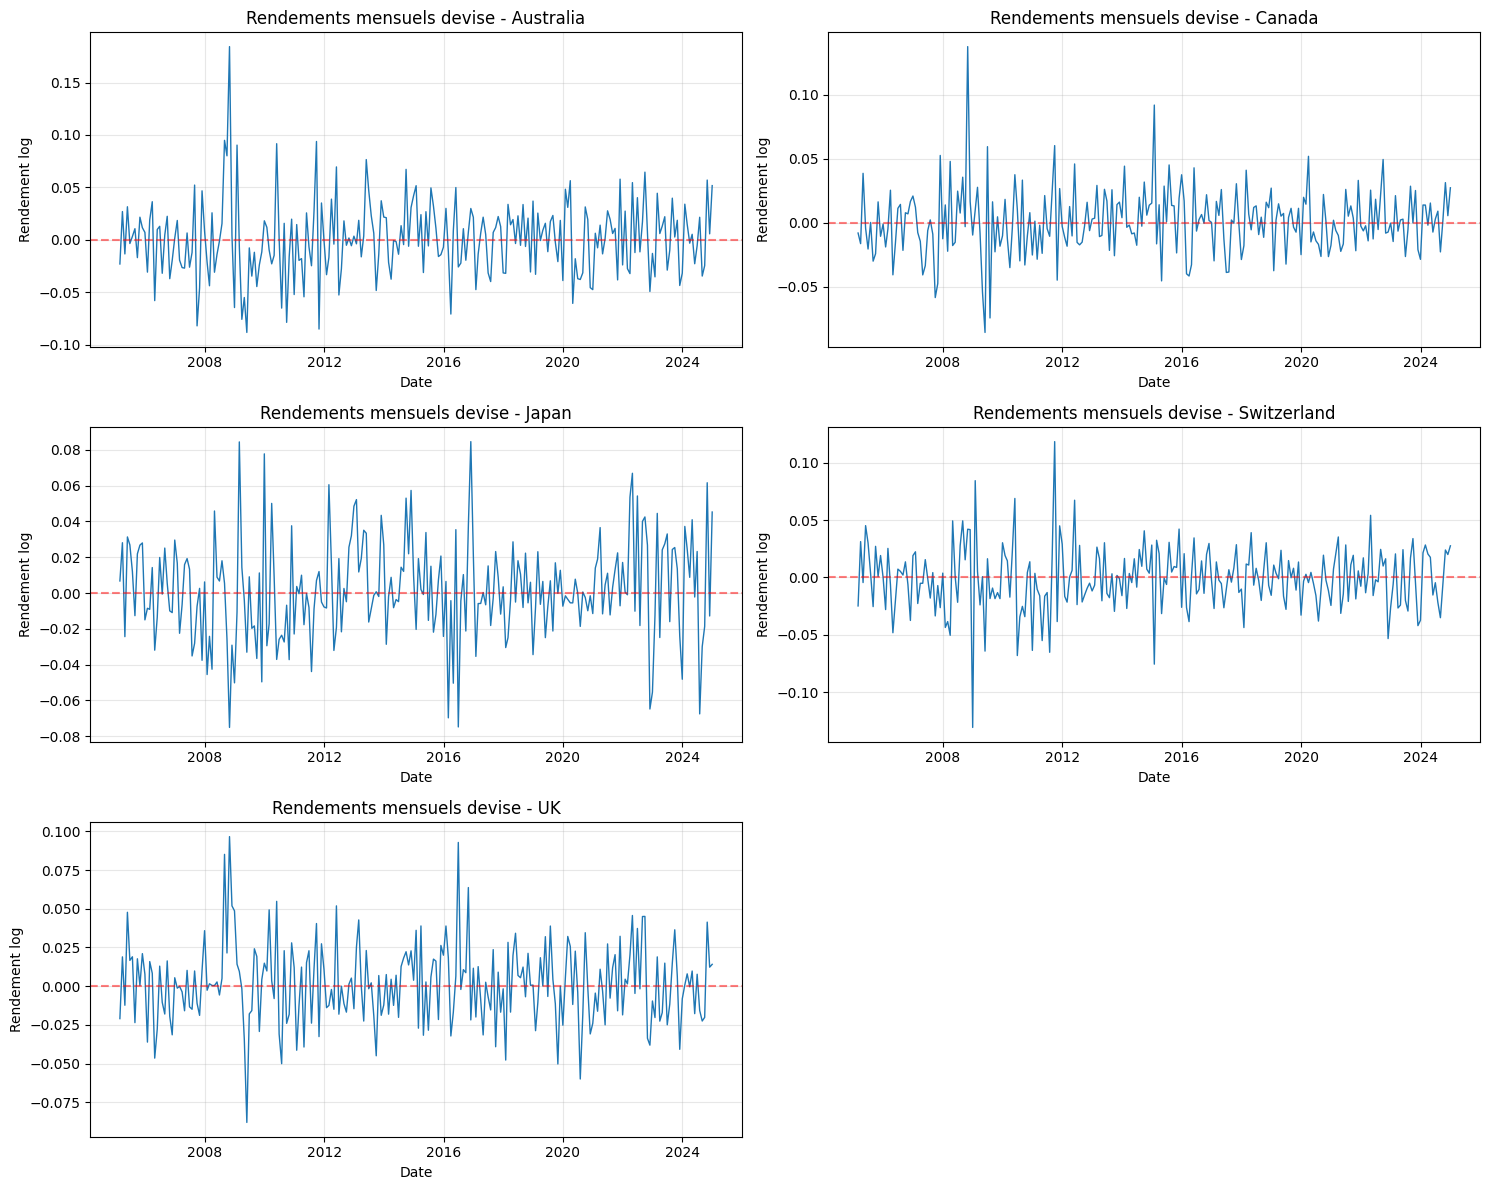

In [10]:
# Visualiser les rendements des 5 devises
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

# Liste des 5 devises (exclure la colonne 'date')
currencies_list = ['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']

for i, col in enumerate(currencies_list):
    axes[i].plot(returns['date'], returns[col], linewidth=1)
    axes[i].set_title(f'Rendements mensuels devise - {col}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Rendement log')
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Masquer le dernier subplot (6ème)
axes[5].axis('off')

plt.tight_layout()
plt.show()

# Analyse en Composantes Principales (ACP)

## Objectif
Effectuer une ACP sur les rendements des 5 devises pour identifier les facteurs communs qui expliquent les co-mouvements des devises.

## Méthodologie
L'ACP sera réalisée manuellement (sans utiliser sklearn.PCA) en suivant ces étapes :
1. Centrer les données (soustraire la moyenne)
2. Calculer la matrice de variance-covariance
3. Extraire les valeurs propres et vecteurs propres
4. Calculer les composantes principales
5. Analyser la variance expliquée

## Étape 1 : Préparation des données pour l'ACP

**Transformation requise** : Standardisation des données

La standardisation consiste à :

1. **Centrer** : Soustraire la moyenne de chaque variableCette étape met toutes les variables sur la même échelle (moyenne = 0, écart-type = 1), ce qui est équivalent à faire une ACP sur la **matrice de corrélation**.

2. **Réduire** : Diviser par l'écart-type de chaque variable

Formule : $Z = \frac{X - \mu}{\sigma}$

In [11]:
# Extraire uniquement les colonnes des rendements (sans 'date')
returns_matrix = returns[['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']].values

# Afficher les dimensions
print(f"Dimensions de la matrice des rendements : {returns_matrix.shape}")
print(f"  - {returns_matrix.shape[0]} observations (mois)")
print(f"  - {returns_matrix.shape[1]} variables (devises)")

# Standardiser les données : (X - moyenne) / écart-type
returns_mean = np.mean(returns_matrix, axis=0)
returns_std = np.std(returns_matrix, axis=0, ddof=1)  # ddof=1 pour écart-type non biaisé
returns_standardized = (returns_matrix - returns_mean) / returns_std

print(f"\n📊 Statistiques avant standardisation :")
for i, currency in enumerate(['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']):
    print(f"  {currency}: moyenne = {returns_mean[i]:.6f}, écart-type = {returns_std[i]:.6f}")

print(f"\n✅ Vérification de la standardisation :")
std_means = np.mean(returns_standardized, axis=0)
std_stds = np.std(returns_standardized, axis=0, ddof=1)

for i, currency in enumerate(['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']):    print(f"  {currency}: moyenne = {std_means[i]:.2e}, écart-type = {std_stds[i]:.4f}")

Dimensions de la matrice des rendements : (239, 5)
  - 239 observations (mois)
  - 5 variables (devises)

📊 Statistiques avant standardisation :
  Australia: moyenne = 0.000949, écart-type = 0.035571
  Canada: moyenne = 0.000627, écart-type = 0.025482
  Japan: moyenne = 0.001751, écart-type = 0.027461
  Switzerland: moyenne = -0.001129, écart-type = 0.027786
  UK: moyenne = 0.001712, écart-type = 0.025619

✅ Vérification de la standardisation :
  Australia: moyenne = 0.00e+00, écart-type = 1.0000
  Canada: moyenne = -7.43e-18, écart-type = 1.0000
  Japan: moyenne = -4.09e-17, écart-type = 1.0000
  Switzerland: moyenne = -1.49e-17, écart-type = 1.0000
  UK: moyenne = 5.57e-18, écart-type = 1.0000


## Étape 2 : Calcul de la matrice de variance

Sur des données standardisées, la matrice de variance-covariance devient la **matrice de variance**.

La matrice de variance capture les relations linéaires entre les devises, indépendamment de leurs échelles.

**Formule** : $R = \frac{1}{n-1} Z^T Z$ où $Z$ est la matrice standardisée

In [14]:
# Calculer la matrice de covariance des données standardisées
n = returns_standardized.shape[0]
cov_matrix_standardized = (returns_standardized.T @ returns_standardized) / (n - 1)

print("📊 Matrice de covariance des données standardisées :")
print("(Note : cette matrice est équivalente à la matrice de corrélation)")
print(pd.DataFrame(
    cov_matrix_standardized,
    index=['Australia', 'Canada', 'Japan', 'Switzerland', 'UK'],
    columns=['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']
).round(4))

# Calculer aussi la matrice de covariance des données originales (non standardisées)
cov_matrix_original = (returns_matrix.T @ (returns_matrix - returns_mean)) / (n - 1)

print("\n📊 Matrice de covariance des données originales (non standardisées) :")
print(pd.DataFrame(
    cov_matrix_original,
    index=['Australia', 'Canada', 'Japan', 'Switzerland', 'UK'],
    columns=['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']
).round(6))

# Vérification : la diagonale doit être ~1.0 pour les données standardisées
print(f"\n✅ Vérification : Diagonale de la matrice standardisée (doit être ≈ 1.0) :")
print(f"  {np.diag(cov_matrix_standardized)}")

📊 Matrice de covariance des données standardisées :
(Note : cette matrice est équivalente à la matrice de corrélation)
             Australia  Canada   Japan  Switzerland      UK
Australia       1.0000  0.7442  0.1649       0.5881  0.5878
Canada          0.7442  1.0000  0.0704       0.3813  0.5541
Japan           0.1649  0.0704  1.0000       0.4115  0.1019
Switzerland     0.5881  0.3813  0.4115       1.0000  0.4835
UK              0.5878  0.5541  0.1019       0.4835  1.0000

📊 Matrice de covariance des données originales (non standardisées) :
             Australia    Canada     Japan  Switzerland        UK
Australia     0.001265  0.000675  0.000161     0.000581  0.000536
Canada        0.000675  0.000649  0.000049     0.000270  0.000362
Japan         0.000161  0.000049  0.000754     0.000314  0.000072
Switzerland   0.000581  0.000270  0.000314     0.000772  0.000344
UK            0.000536  0.000362  0.000072     0.000344  0.000656

✅ Vérification : Diagonale de la matrice standardisée 

### 📊 Interprétation de la matrice de corrélation

**Que représente cette matrice ?**
- Chaque élément mesure la **corrélation linéaire** entre deux devises (valeurs entre -1 et +1)
- Valeurs proches de +1 : co-mouvements positifs (devises qui bougent ensemble)
- Valeurs proches de 0 : mouvements indépendants
- Valeurs négatives : mouvements opposés

**Principaux constats** :

1. **Corrélation très forte : AUD-CAD (0.74)**
   - Économies similaires : exportateurs de matières premières, liés au cycle économique US
   - Bougent ensemble face aux chocs globaux

2. **Corrélation modérée-forte : AUD-CHF (0.59), AUD-UK (0.59), CAD-UK (0.55)**
   - Économies développées avec liens commerciaux importants
   - Réagissent similairement aux chocs de risque global

3. **Corrélation faible : JPY avec les autres (0.07-0.17)**
   - **JPY = safe haven** : comportement différent des autres devises
   - Monte quand les autres baissent en période de crise (aversion au risque)
   - Confirme le rôle unique du yen comme valeur refuge

4. **CHF-JPY modérée (0.41)**
   - Deux devises "safe haven" avec comportements partiellement similaires

**Ce que cela nous apprend** :
- Existence de **co-mouvements communs** justifiant l'ACP
- JPY nécessaire pour capturer la dimension "safe haven"
- L'ACP devrait révéler : PC1 = facteur commun (risque global), PC2 = contraste JPY vs autres

## Étape 3 : Extraction des valeurs propres et vecteurs propres

Les valeurs propres indiquent la variance expliquée par chaque composante principale.
Les vecteurs propres indiquent la direction (combinaison linéaire des devises) de chaque composante.

**Fonction autorisée** : `np.linalg.eig()` pour calculer eigenvalues et eigenvectors

In [ ]:
# Calculer les valeurs propres et vecteurs propres de la matrice de corrélation
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix_standardized)

# Trier par ordre décroissant des valeurs propres
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print("📊 Valeurs propres (variance expliquée par chaque PC) :")
for i, val in enumerate(eigenvalues, 1):
    print(f"  PC{i}: {val:.6f}")

print("\n📊 Vecteurs propres (loadings - poids de chaque devise dans les PCs) :")
loadings_df = pd.DataFrame(
    eigenvectors,
    index=['Australia', 'Canada', 'Japan', 'Switzerland', 'UK'],
    columns=[f'PC{i}' for i in range(1, len(eigenvalues) + 1)]
)
print(loadings_df.round(4))

📊 Valeurs propres (variance expliquée par chaque PC) :
  PC1: 2.757544
  PC2: 1.091808
  PC3: 0.509530
  PC4: 0.432553
  PC5: 0.208564

📊 Vecteurs propres (loadings - poids de chaque devise dans les PCs) :
                PC1     PC2     PC3     PC4     PC5
Australia   -0.5365 -0.1560  0.2550  0.2730 -0.7404
Canada      -0.4842 -0.3305  0.5613 -0.1072  0.5742
Japan       -0.2053  0.8381  0.3093 -0.3941 -0.0666
Switzerland -0.4622  0.3545 -0.4209  0.6071  0.3391
UK          -0.4711 -0.1958 -0.5891 -0.6246 -0.0506


### 📊 Interprétation des valeurs propres et vecteurs propres

**1. Valeurs propres - Importance de chaque composante**

| PC | Valeur propre | % Variance | Interprétation |
|----|---------------|------------|----------------|
| PC1 | 2.76 | 55% | **Facteur dominant** - capture plus de la moitié de la variabilité totale |
| PC2 | 1.09 | 22% | **Facteur secondaire important** - ajoute dimension significative |
| PC3 | 0.51 | 10% | Facteur tertiaire - information additionnelle modérée |
| PC4 | 0.43 | 9% | Contribution mineure |
| PC5 | 0.21 | 4% | Bruit résiduel |

**Conclusion** : Les 2 premières composantes expliquent **77% de la variance** → réduction de dimension efficace (5 devises → 2 facteurs principaux)

---

**2. Vecteurs propres (Loadings) - Composition des facteurs**

**PC1 - Facteur de co-mouvement global (55% variance)**
- Tous les poids sont **négatifs** et relativement équilibrés
- AUD (-0.54), CAN (-0.48), UK (-0.47), CHF (-0.46), JPY (-0.21)
- **Interprétation économique** : Facteur "risque global" ou "sentiment de marché"
  - Quand PC1 ↑ : toutes les devises se déprécient ensemble vs USD (aversion au risque)
  - Quand PC1 ↓ : toutes les devises s'apprécient vs USD (appétit pour le risque)
- JPY a le poids le plus faible → confirme son comportement partiellement distinct

**PC2 - Facteur safe haven vs cycliques (22% variance)**
- **JPY (+0.84)** : poids très positif et dominant
- **AUD, CAN, UK** : poids négatifs (-0.16, -0.33, -0.20)
- CHF (+0.35) : poids positif mais plus faible que JPY
- **Interprétation économique** : Contraste "safe haven vs devises cycliques"
  - Quand PC2 ↑ : JPY et CHF s'apprécient, devises cycliques se déprécient (fuite vers sécurité)
  - Quand PC2 ↓ : devises cycliques s'apprécient, safe havens se déprécient (recherche de rendement)

**PC3 - Facteurs régionaux/spécifiques (10% variance)**
- Structure plus complexe, capture des dynamiques régionales spécifiques
- Importance secondaire pour le modèle factoriel principal

---

**3. Implications pour la suite**

Ces résultats suggèrent que les facteurs économiques à rechercher devraient inclure :
- **Pour PC1** : VIX (volatilité), indices boursiers globaux, sentiment de risque
- **Pour PC2** : Spreads de crédit, indices de stress financier, or
- **Pour PC3** : Prix des matières premières (différencier AUD/CAD des autres)

## Étape 4 : Calcul des composantes principales

Les composantes principales sont les projections des données **standardisées** sur les vecteurs propres.

**Formule** : $PC = Z \times \text{Eigenvectors}$ où $Z$ est la matrice standardisée

In [27]:
# Calculer les composantes principales
principal_components = returns_standardized @ eigenvectors

# Créer un DataFrame avec les PCs
pc_df = pd.DataFrame(
    principal_components,
    columns=[f'PC{i}' for i in range(1, len(currencies_list) + 1)]
)
pc_df.insert(0, 'date', returns['date'].values)

print(f"📊 Composantes principales calculées :")
print(f"  Dimensions : {principal_components.shape}")

print(f"\nStatistiques descriptives des PCs :")
print(pc_df[[f'PC{i}' for i in range(1, len(currencies_list) + 1)]].describe())

pc_df

📊 Composantes principales calculées :
  Dimensions : (239, 5)

Statistiques descriptives des PCs :
                PC1           PC2           PC3           PC4           PC5
count  2.390000e+02  2.390000e+02  2.390000e+02  2.390000e+02  2.390000e+02
mean   2.229737e-17 -1.486491e-17 -2.229737e-17  1.091642e-17  1.521331e-17
std    1.660586e+00  1.044896e+00  7.138137e-01  6.576877e-01  4.566886e-01
min   -7.251470e+00 -5.096448e+00 -3.109112e+00 -3.693281e+00 -1.505506e+00
25%   -9.992429e-01 -5.365445e-01 -4.388786e-01 -3.643523e-01 -2.791522e-01
50%   -6.133406e-02  6.066465e-02 -3.256196e-03  4.614960e-02  2.381529e-02
75%    1.135693e+00  6.359819e-01  4.883913e-01  3.981841e-01  2.872323e-01
max    5.950056e+00  2.958605e+00  2.461350e+00  2.386167e+00  1.734973e+00


,date,PC1,PC2,PC3,PC4,PC5
0,2005-02-28,1.304160,0.241623,0.570996,-0.185572,0.043933
1,2005-03-31,-1.117985,1.192639,-0.779512,0.179617,-0.629984
2,2005-04-30,0.008901,-1.160232,0.809472,0.372393,1.202394
3,2005-05-31,-2.200446,1.073174,-1.318314,-0.279849,-0.349261
4,2005-06-30,-0.508901,1.346459,-1.034749,0.012171,-0.095962
...,...,...,...,...,...,...
234,2024-08-31,2.231513,-0.754078,-0.058139,0.126895,-0.081994
235,2024-09-30,1.004822,-0.412716,0.174593,0.524185,0.585137
236,2024-10-31,-3.018125,1.200274,0.458057,-0.978000,-0.395869
237,2024-11-30,-0.596917,-0.338984,-0.587899,0.427386,0.279945


## Étape 5 : Analyse de la variance expliquée

**Objectif** : Déterminer l'importance relative de chaque composante principale.

**Calculs** :
- **Variance expliquée** : Proportion = Valeur propre / Somme des valeurs propres
- **Variance cumulée** : Somme cumulative des proportions

**Interprétation** :
- Les valeurs propres mesurent la **variance totale** capturée par chaque PC
- La proportion indique le **% de variance** expliquée (ex: PC1 = 55% signifie que PC1 capture 55% de la variabilité totale)
- La variance cumulée aide à choisir combien de PCs garder (critère : 80-90%)

**Note importante** : 
- Valeurs propres ≠ Bêtas de régression (les bêtas viendront plus tard avec les facteurs économiques)
- Moyenne des PCs ≈ 0 (normal, car données standardisées)

In [ ]:
# Calculer la variance expliquée (en proportion)
total_variance = np.sum(eigenvalues)
explained_variance_ratio = eigenvalues / total_variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Créer un tableau récapitulatif
variance_df = pd.DataFrame({
    'Composante': [f'PC{i}' for i in range(1, len(eigenvalues) + 1)],
    'Valeur propre': eigenvalues,
    'Variance expliquée (%)': explained_variance_ratio * 100,
    'Variance cumulée (%)': cumulative_variance * 100
})

print("📊 Tableau de variance expliquée :")
print(variance_df.round(2))

# Afficher un résumé
print(f"\n✅ Résumé :")
print(f"  - PC1 explique {explained_variance_ratio[0]*100:.2f}% de la variance")
print(f"  - PC1 + PC2 expliquent {cumulative_variance[1]*100:.2f}% de la variance")
print(f"  - PC1 + PC2 + PC3 expliquent {cumulative_variance[2]*100:.2f}% de la variance")

📊 Tableau de variance expliquée :
  Composante  Valeur propre  Variance expliquée (%)  Variance cumulée (%)
0        PC1           2.76                   55.15                 55.15
1        PC2           1.09                   21.84                 76.99
2        PC3           0.51                   10.19                 87.18
3        PC4           0.43                    8.65                 95.83
4        PC5           0.21                    4.17                100.00

✅ Résumé :
  - PC1 explique 55.15% de la variance
  - PC1 + PC2 expliquent 76.99% de la variance
  - PC1 + PC2 + PC3 expliquent 87.18% de la variance


### 📊 Interprétation de la variance expliquée

**1. Performance de la réduction dimensionnelle**

La règle du coude ("elbow rule") et le critère de Kaiser (valeur propre > 1) suggèrent de **retenir 2 composantes principales** :
- PC1 (valeur propre = 2.76 > 1) ✓
- PC2 (valeur propre = 1.09 > 1) ✓  
- PC3-PC5 (valeurs propres < 1) → peuvent être considérés comme du bruit

**Réduction réussie** : 5 devises → 2 facteurs principaux (capture 77% de l'information)

---

**2. Distribution de la variance**

| Critère | Résultat | Évaluation |
|---------|----------|------------|
| **PC1 seul** | 55.15% | Très bon - un seul facteur explique plus de la moitié |
| **PC1 + PC2** | 76.99% | Excellent - seuil typique 70-80% atteint |
| **PC1 + PC2 + PC3** | 87.18% | Seuil conservateur 85% dépassé |

**Déséquilibre des contributions** :
- PC1 (55%) : domine largement → forte synchronisation des devises
- PC2 (22%) : apport substantiel → deuxième dimension distincte importante  
- PC3-PC5 (23% combinés) : contributions marginales décroissantes

---

**3. Implications économiques**

**✓ PC1 dominant (55%) confirme** :
- Forte intégration des marchés de devises
- Exposition commune à des chocs macroéconomiques globaux
- Un facteur de risque systématique majeur affecte toutes les devises

**✓ PC2 significatif (22%) révèle** :
- Hétérogénéité résiduelle importante après PC1
- Deuxième dimension économique orthogonale (safe haven vs cycliques)
- Ne peut pas réduire à un seul facteur global

**✓ PC3+ modestes (23%) indiquent** :
- Bruit idiosyncratique limité
- Pas de facteurs régionaux/spécifiques dominants supplémentaires
- Modèle parcimonieux à 2-3 facteurs est approprié

---

**4. Décision pour le modèle factoriel**

**Recommandation** : Utiliser **2 composantes principales** (PC1 + PC2) pour la suite
- Respecte le critère de Kaiser (valeurs propres > 1)
- Capture 77% de variance (seuil standard)
- Parcimonie du modèle : 2 facteurs faciles à interpréter économiquement
- PC3 optionnel si analyse plus fine nécessaire (atteindre 87%)

**Prochaine étape** : Régresser PC1 et PC2 sur des facteurs économiques communs (VIX, spreads, prix matières premières) pour identifier leur nature économique.

## Étape 6 : Visualisations de l'ACP

### 6.1 Scree Plot (Graphique des valeurs propres)

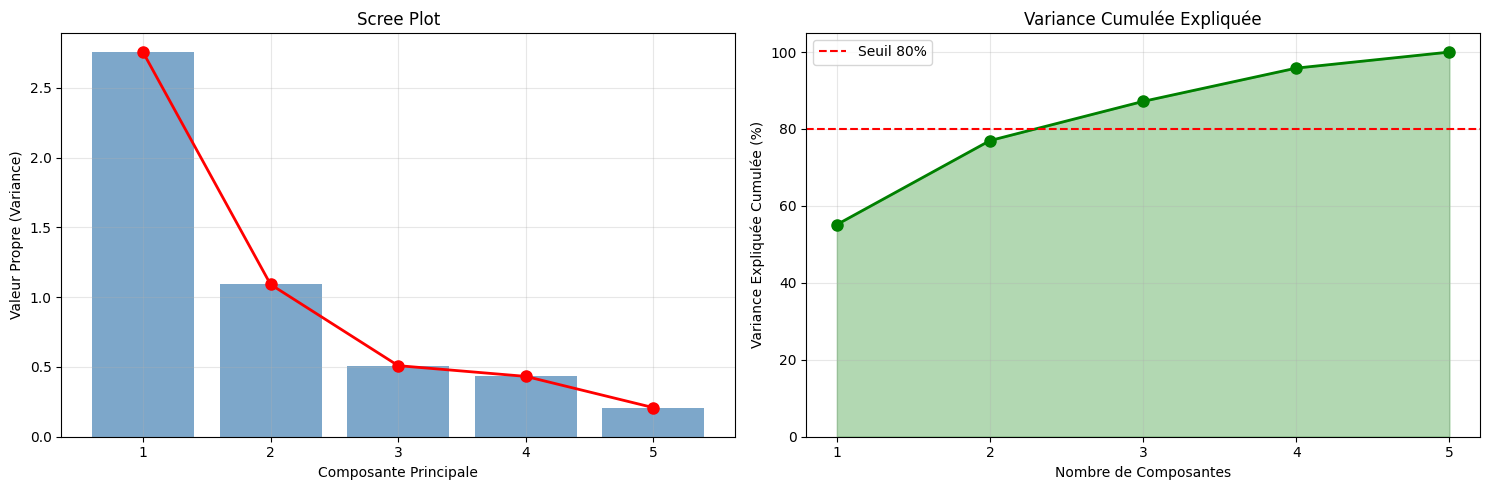

In [29]:
# Scree plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

n_components = len(eigenvalues)

# Graphique des valeurs propres
ax1.bar(range(1, n_components + 1), eigenvalues, alpha=0.7, color='steelblue')
ax1.plot(range(1, n_components + 1), eigenvalues, 'ro-', linewidth=2, markersize=8)
ax1.set_xlabel('Composante Principale')
ax1.set_ylabel('Valeur Propre (Variance)')
ax1.set_title('Scree Plot')
ax1.set_xticks(range(1, n_components + 1))
ax1.grid(True, alpha=0.3)

# Graphique de la variance cumulée
ax2.plot(range(1, n_components + 1), cumulative_variance * 100, 'go-', linewidth=2, markersize=8)
ax2.axhline(y=80, color='r', linestyle='--', label='Seuil 80%')
ax2.fill_between(range(1, n_components + 1), cumulative_variance * 100, alpha=0.3, color='green')
ax2.set_xlabel('Nombre de Composantes')
ax2.set_ylabel('Variance Expliquée Cumulée (%)')
ax2.set_title('Variance Cumulée Expliquée')
ax2.set_xticks(range(1, n_components + 1))
ax2.set_ylim([0, 105])
ax2.grid(True, alpha=0.3)
ax2.legend()


plt.tight_layout()
plt.show()

## Documentation des transformations effectuées

**Résumé des étapes de l'ACP** :

1. ✅ **Données d'entrée** : Matrice des rendements logarithmiques mensuels (239 × 5)
2. ✅ **Standardisation** : $(X - \mu) / \sigma$ pour chaque devise
   - Centrage : soustraction de la moyenne
   - Réduction : division par l'écart-type
3. ✅ **Matrice de corrélation** : Calcul de $R = \frac{1}{n-1} Z^T Z$ où $Z$ est standardisé
4. ✅ **Décomposition spectrale** : Extraction des valeurs/vecteurs propres via `np.linalg.eig()`
5. ✅ **Tri** : Classement par valeurs propres décroissantes
6. ✅ **Projection** : Calcul des PCs via $PC = Z \times \text{Eigenvectors}$

**Choix de la standardisation** :
- Met toutes les devises sur la même échelle (moyenne = 0, écart-type = 1)
- Équivalent à une ACP sur la **matrice de corrélation** plutôt que covariance
- Donne le même poids à chaque devise dans l'analyse
- Recommandé quand les variables ont des variances différentes

# Construction du Modèle Factoriel

---

## 📋 Plan de match : De l'ACP au Modèle Factoriel

### **Phase 1 : Facteurs latents identifiés (✅ COMPLÉTÉ)**

L'ACP a révélé **3 facteurs latents** qui expliquent 87% de la variance des rendements de devises :

| Facteur Latent | Variance | Interprétation préliminaire |
|----------------|----------|----------------------------|
| **PC1** | 55.15% | Co-mouvement global / Risque systématique |
| **PC2** | 21.84% | Safe haven vs devises cycliques |
| **PC3** | 10.19% | Facteurs régionaux / Matières premières |

**Caractéristiques des facteurs latents :**
- ✓ Non directement observables sur les marchés
- ✓ Extraits mathématiquement des co-mouvements des devises
- ✓ Orthogonaux entre eux (indépendants par construction)
- ✓ Capturent les sources de risque communes

---

### **Phase 2 : Identification des facteurs observables (🔄 EN COURS)**

**Objectif** : Relier les facteurs latents (PCs) à des variables économiques réelles et observables

**Stratégie de sélection des facteurs :**

#### **Pour expliquer PC1 (Risque global - 55%)** :
Hypothèse : PC1 capture le sentiment de risque macroéconomique global

**Facteurs candidats :**
- **VIX** (CBOE Volatility Index) : mesure de la volatilité et de la peur sur les marchés
- **S&P 500 returns** : performance des marchés actions (proxy du risk-on/risk-off)
- **US 10Y Treasury yield changes** : taux sans risque et anticipations macro
- **Global PMI / Economic Surprise Index** : activité économique mondiale

**Justification :** Ces facteurs influencent simultanément toutes les devises via l'appétit pour le risque global

---

#### **Pour expliquer PC2 (Safe haven - 22%)** :
Hypothèse : PC2 capture le contraste entre devises refuges (JPY, CHF) et devises cycliques

**Facteurs candidats :**
- **Gold returns** : actif refuge par excellence
- **Credit spreads** (BAA-AAA ou High Yield spreads) : stress financier
- **TED spread** : prime de risque interbancaire
- **Currency volatility indices** : mesure du stress sur le marché des devises
- **Geopolitical risk index** : tensions géopolitiques

**Justification :** Ces facteurs distinguent les périodes de fuite vers la qualité (PC2 ↑, JPY ↑) des périodes de recherche de rendement

---

#### **Pour expliquer PC3 (Régional/Commodités - 10%)** :
Hypothèse : PC3 capture les dynamiques spécifiques aux économies exportatrices de matières premières

**Facteurs candidats :**
- **WTI/Brent Oil prices** : pétrole (important pour CAD)
- **Bloomberg Commodity Index** : panier diversifié de matières premières
- **Metals prices** (copper, iron ore) : important pour AUD
- **Terms of trade differentials** : pouvoir d'achat relatif des exportations

**Justification :** AUD et CAD ont des poids élevés en valeur absolue sur PC3, ce sont des devises de matières premières

---

### **Phase 3 : Méthodologie de régression (📝 À VENIR)**

**Modèle économétrique :**

Pour chaque facteur latent $PC_i$, on estime :

$$PC_{i,t} = \alpha_i + \beta_{i,1} F_{1,t} + \beta_{i,2} F_{2,t} + ... + \beta_{i,k} F_{k,t} + \varepsilon_{i,t}$$

où :
- $PC_{i,t}$ = score du facteur latent $i$ au temps $t$
- $F_{j,t}$ = facteur observable $j$ au temps $t$
- $\beta_{i,j}$ = sensibilité du facteur latent $i$ au facteur observable $j$
- $\varepsilon_{i,t}$ = résidu (partie non expliquée)

**Stratégie de modélisation :**

1. **Modèles univariés** : Tester chaque facteur individuellement (R² de référence)
2. **Modèles multivariés** : Combiner plusieurs facteurs pertinents
3. **Sélection de variables** : 
   - Forward selection (ajouter progressivement)
   - Backward elimination (retirer les non-significatifs)
   - Critère d'information (AIC, BIC)
4. **Validation** : 
   - Significativité statistique (p-values < 0.05)
   - Cohérence économique (signes attendus)
   - Stabilité temporelle (sous-périodes)

**Métriques d'évaluation :**
- R² ajusté : pouvoir explicatif global
- Coefficients β : direction et magnitude de l'effet
- T-statistiques : significativité individuelle
- Tests de diagnostic : autocorrélation, hétéroscédasticité

---

### **Phase 4 : Interprétation attendue (🎯 OBJECTIF FINAL)**

**Résultat espéré :**

Une fois les régressions effectuées, nous pourrons dire :

> *"Le premier facteur latent (PC1) représente le **risque global**, fortement corrélé avec le VIX (β = X.XX, p < 0.001) et le S&P 500 (β = Y.YY, p < 0.01), expliquant Z% de sa variance."*

> *"Le deuxième facteur latent (PC2) capture l'**aversion au risque**, positivement lié au prix de l'or (β = X.XX) et aux spreads de crédit (β = Y.YY), confirmant la dimension safe haven."*

> *"Le troisième facteur latent (PC3) est influencé par les **prix des matières premières**, expliquant les mouvements spécifiques de l'AUD et du CAD."*

**Factor loadings sur les devises originales :**

En combinant les eigenvectors (de l'ACP) et les β (des régressions), nous obtiendrons l'exposition de chaque devise à chaque facteur observable :

$$\text{Sensibilité}_{devise,facteur} = \sum_{i=1}^{3} w_{devise,PC_i} \times \beta_{PC_i,facteur}$$

Exemple : *"L'AUD est exposé positivement au risque global (via PC1) et aux matières premières (via PC3), mais négativement au safe haven (via PC2)."*

---

### **Phase 5 : Collecte des données (🔍 PROCHAINE ÉTAPE)**

**Actions immédiates :**

1. ✅ Télécharger les séries temporelles des facteurs observables (2005-2024, mensuel)
2. ✅ Harmoniser les dates avec les PCs
3. ✅ Calculer les variations/rendements si nécessaire
4. ✅ Créer une matrice de corrélation préliminaire (PCs vs facteurs)
5. ✅ Visualiser les relations temporelles

**Sources de données potentielles :**
- VIX, S&P500 : Yahoo Finance, FRED
- Taux US : FRED (Federal Reserve Economic Data)
- Or, Pétrole : Yahoo Finance, EIA
- Spreads : FRED, Bloomberg
- Indices économiques : OECD, Haver Analytics

---

## 🎓 Concepts clés à retenir

**Facteurs latents vs Facteurs observables :**
- **Latents (PCs)** : variables cachées extraites des données, non directement mesurables
- **Observables (VIX, etc.)** : variables réelles cotées sur les marchés

**Modèle factoriel** : système qui relie les deux types de facteurs pour donner une interprétation économique aux facteurs latents

**Avantage de l'approche** : 
- Réduction de dimension (5 devises → 3 facteurs latents)
- Interprétation économique (facteurs latents → facteurs observables)
- Parcimonie (quelques facteurs communs expliquent la plupart de la variance)

---

**🚀 Prochaine étape : Collecte et préparation des données des facteurs observables**

# Modèle Factoriel Global - 1er ESSAI

## Objectif
Construire un modèle factoriel en régressant les rendements des devises sur des facteurs observables communs. Comparer la variance expliquée par ce modèle avec celle de l'ACP (87%).

## Approche
1. Collecter les facteurs observables (VIX, Or, Pétrole, S&P500, etc.)
2. Harmoniser avec la fréquence mensuelle (2005-2024)
3. Empiler les rendements des 5 devises (pooled regression)
4. Tester différentes spécifications du modèle
5. Comparer les performances

## Étape 1 : Collecte des facteurs observables

Nous allons télécharger les séries temporelles suivantes :
- **VIX** : Indice de volatilité (mesure de peur/incertitude sur les marchés)
- **S&P 500** : Indice boursier US (proxy du sentiment risque global)
- **Gold (Or)** : Actif refuge
- **WTI Oil (Pétrole)** : Prix du pétrole (important pour économies exportatrices)
- **US 10Y Treasury Yield** : Taux sans risque

### PC1 = VIX
le plus sensible pour toutes donc facteur global - risque de marché

In [31]:
# Connexion à WRDS
db = wrds.Connection()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
Done


In [51]:
# Télécharger le VIX depuis CBOE (disponible via WRDS)
# Le VIX est dans la base de données cboe
# Commencer en 2005-01 pour avoir le niveau de janvier nécessaire au calcul du rendement de février 2005
vix_query = """
SELECT
    date,
    vix
FROM cboe.cboe
WHERE date >= '2005-01-01'
  AND date <= '2024-12-31'
  AND vix IS NOT NULL
ORDER BY date
"""

vix_data = db.raw_sql(vix_query)
vix_data['date'] = pd.to_datetime(vix_data['date'])

print(f"Période : {vix_data['date'].min()} à {vix_data['date'].max()}")
print(f"Observations : {len(vix_data)}")

vix_data

Période : 2005-01-03 00:00:00 à 2024-12-31 00:00:00
Observations : 5052


,date,vix
0,2005-01-03,14.08
1,2005-01-04,13.98
2,2005-01-05,14.09
3,2005-01-06,13.58
4,2005-01-07,13.49
...,...,...
5047,2024-12-24,14.27
5048,2024-12-26,14.73
5049,2024-12-27,15.95
5050,2024-12-30,17.4


In [52]:
# Convertir VIX en fréquence mensuelle (fin de mois)
vix_temp = vix_data.copy()
if 'date' in vix_temp.columns:
    vix_temp = vix_temp.set_index('date')
vix_monthly = vix_temp.resample('ME').last()  # Prendre la dernière valeur du mois
vix_monthly = vix_monthly.dropna()
vix_monthly = vix_monthly.reset_index()

print(f"Période : {vix_monthly['date'].min()} à {vix_monthly['date'].max()}")
print(f"Observations mensuelles : {len(vix_monthly)}")
print(f"\nStatistiques descriptives :")
print(vix_monthly['vix'].describe())

vix_monthly

Période : 2005-01-31 00:00:00 à 2024-12-31 00:00:00
Observations mensuelles : 240

Statistiques descriptives :
count        240.0
mean     19.301208
std       8.260982
min           9.51
25%         13.535
50%          16.81
75%          22.99
max          59.89
Name: vix, dtype: Float64


,date,vix
0,2005-01-31,12.82
1,2005-02-28,12.08
2,2005-03-31,14.02
3,2005-04-30,15.31
4,2005-05-31,13.29
...,...,...
235,2024-08-31,15.0
236,2024-09-30,16.73
237,2024-10-31,23.16
238,2024-11-30,13.51


In [53]:
# Calculer le rendement logarithmique du VIX (cohérent avec les devises)
vix_monthly['vix_return'] = np.log(vix_monthly['vix'] / vix_monthly['vix'].shift(1))

# Supprimer la première observation (NA)
vix_monthly = vix_monthly.dropna()

print(f"Période : {vix_monthly['date'].min()} à {vix_monthly['date'].max()}")
print(f"Observations : {len(vix_monthly)}")
print(f"\nStatistiques des rendements log du VIX :")
print(vix_monthly['vix_return'].describe())
print(f"\nVérification : devises ont {len(returns)} observations")
print(f"Alignement : {'✅ OK' if len(vix_monthly) == len(returns) else '⚠️ À vérifier'}")

vix_monthly[['date', 'vix', 'vix_return']]

Période : 2005-02-28 00:00:00 à 2024-12-31 00:00:00
Observations : 239

Statistiques des rendements log du VIX :
count       239.0
mean     0.001266
std      0.227047
min     -0.614279
25%     -0.149676
50%     -0.017265
75%      0.119736
max      0.852588
Name: vix_return, dtype: Float64

Vérification : devises ont 239 observations
Alignement : ✅ OK


,date,vix,vix_return
1,2005-02-28,12.08,-0.059455
2,2005-03-31,14.02,0.148934
3,2005-04-30,15.31,0.088021
4,2005-05-31,13.29,-0.141494
5,2005-06-30,12.04,-0.098777
...,...,...,...
235,2024-08-31,15.0,-0.086789
236,2024-09-30,16.73,0.109153
237,2024-10-31,23.16,0.325223
238,2024-11-30,13.51,-0.538997


### 2.2 Term Spread 10Y-2Y (Facteur pour PC2)

Le term spread (pente de la courbe des taux) mesure la différence entre les taux longs (10 ans) et courts (2 ans). Un spread positif élevé indique des anticipations de croissance économique, favorisant les devises cycliques (AUD, CAD, GBP). Un spread faible ou négatif (inversion) signale des anticipations de récession, favorisant les devises safe haven (JPY, CHF).

In [84]:
# Charger le Term Spread 10Y-2Y depuis le fichier CSV téléchargé depuis FRED
# Source : Federal Reserve Bank of St. Louis, série T10Y2Y
# "10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity"

term_spread_data = pd.read_csv('T10Y2Y.csv')
term_spread_data.columns = ['date', 'term_spread']
term_spread_data['date'] = pd.to_datetime(term_spread_data['date'])

print(f"📊 Term Spread chargé depuis T10Y2Y.csv")
print(f"Observations : {len(term_spread_data)}")
print(f"Période : {term_spread_data['date'].min()} à {term_spread_data['date'].max()}")
print(f"\nStatistiques descriptives du Term Spread :")
print(term_spread_data['term_spread'].describe())

term_spread_data

📊 Term Spread chargé depuis T10Y2Y.csv
Observations : 5217
Période : 2005-01-03 00:00:00 à 2024-12-31 00:00:00

Statistiques descriptives du Term Spread :
count    5004.000000
mean        0.997190
std         0.965935
min        -1.080000
25%         0.180000
50%         0.960000
75%         1.730000
max         2.910000
Name: term_spread, dtype: float64


,date,term_spread
0,2005-01-03,1.13
1,2005-01-04,1.09
2,2005-01-05,1.07
3,2005-01-06,1.11
4,2005-01-07,1.09
...,...,...
5212,2024-12-25,NaN
5213,2024-12-26,0.28
5214,2024-12-27,0.31
5215,2024-12-30,0.31


In [ ]:
# Convertir en fréquence mensuelle (dernier jour du mois)
term_spread_data = term_spread_data.set_index('date')
term_spread_monthly = term_spread_data.resample('ME').last()
term_spread_monthly = term_spread_monthly.dropna()

# Ajouter une colonne date
term_spread_monthly = term_spread_monthly.reset_index()

print(f"Données mensuelles : {len(term_spread_monthly)} observations")
print(f"Période : {term_spread_monthly['date'].min()} à {term_spread_monthly['date'].max()}")

term_spread_monthly

Données mensuelles : 240 observations
Période : 2005-01-31 00:00:00 à 2024-12-31 00:00:00


,date,term_spread
0,2005-01-31,0.85
1,2005-02-28,0.77
2,2005-03-31,0.70
3,2005-04-30,0.55
4,2005-05-31,0.40
...,...,...
235,2024-08-31,0.00
236,2024-09-30,0.15
237,2024-10-31,0.12
238,2024-11-30,0.05


In [ ]:
# Calculer la variation mensuelle du term spread
# IMPORTANT : Pour le term spread, on utilise la DIFFÉRENCE (Δspread) et non le rendement log
# Le spread est déjà une différence de taux, donc on prend spread(t) - spread(t-1)

term_spread_monthly['spread_change'] = term_spread_monthly['term_spread'].diff()

# Supprimer la première observation (NA)
term_spread_monthly = term_spread_monthly.dropna()

# Ajouter une colonne date pour faciliter les manipulations
term_spread_monthly = term_spread_monthly.reset_index()

print(f"Période : {term_spread_monthly['date'].min()} à {term_spread_monthly['date'].max()}")
print(f"Observations : {len(term_spread_monthly)}")
print(f"\nStatistiques des variations mensuelles du Term Spread :")
print(term_spread_monthly['spread_change'].describe())
print(f"\nVérification : devises ont {len(returns)} observations")
print(f"Alignement : {'✅ OK' if len(term_spread_monthly) == len(returns) else '⚠️ À vérifier'}")

term_spread_monthly[['date', 'term_spread', 'spread_change']]

Période : 2005-02-28 00:00:00 à 2024-12-31 00:00:00
Observations : 239

Statistiques des variations mensuelles du Term Spread :
count    239.000000
mean      -0.002176
std        0.170060
min       -0.520000
25%       -0.100000
50%       -0.020000
75%        0.095000
max        0.600000
Name: spread_change, dtype: float64

Vérification : devises ont 239 observations
Alignement : ✅ OK


,date,term_spread,spread_change
0,2005-02-28,0.77,-0.08
1,2005-03-31,0.70,-0.07
2,2005-04-30,0.55,-0.15
3,2005-05-31,0.40,-0.15
4,2005-06-30,0.28,-0.12
5,2005-07-31,0.26,-0.02
6,2005-08-31,0.18,-0.08
7,2005-09-30,0.16,-0.02
8,2005-10-31,0.17,0.01
9,2005-11-30,0.07,-0.10


### 2.3 CRB Commodity Index (Facteur pour PC3)

L'indice CRB (Commodity Research Bureau) mesure les prix d'un panier diversifié de matières premières (énergie, métaux, agriculture). Un CRB élevé indique une demande forte pour les commodités, favorisant les devises des pays exportateurs de matières premières (AUD, CAD).

In [67]:
# Convertir DBC en fréquence mensuelle et calculer rendements log
commodity_monthly = crb_data.resample('ME').last()
commodity_monthly = commodity_monthly.dropna()

print(f"Données mensuelles : {len(commodity_monthly)} observations")
print(f"Période : {commodity_monthly.index.min()} à {commodity_monthly.index.max()}")

commodity_monthly.head()

Données mensuelles : 227 observations
Période : 2006-02-28 00:00:00 à 2024-12-31 00:00:00


,commodity_price
Date,
2006-02-28,19.085091
2006-03-31,19.617735
2006-04-30,20.994417
2006-05-31,20.912474
2006-06-30,20.732191


In [68]:
# Calculer le rendement logarithmique du Commodity Index (cohérent avec VIX et devises)
commodity_monthly['commodity_return'] = np.log(commodity_monthly['commodity_price'] / commodity_monthly['commodity_price'].shift(1))

# Supprimer la première observation (NA)
commodity_monthly = commodity_monthly.dropna()

# Ajouter une colonne date pour faciliter les manipulations
commodity_monthly = commodity_monthly.reset_index()
commodity_monthly = commodity_monthly.rename(columns={'Date': 'date'})

print(f"Période : {commodity_monthly['date'].min()} à {commodity_monthly['date'].max()}")
print(f"Observations : {len(commodity_monthly)}")
print(f"\nStatistiques des rendements log du Commodity Index :")
print(commodity_monthly['commodity_return'].describe())
print(f"\n⚠️ Note : DBC commence en mars 2006, donc alignement avec devises de mars 2006 à déc 2024")
print(f"Perte de {len(returns) - len(commodity_monthly)} observations par rapport aux devises")

commodity_monthly[['date', 'commodity_price', 'commodity_return']].head(10)

Période : 2006-03-31 00:00:00 à 2024-12-31 00:00:00
Observations : 226

Statistiques des rendements log du Commodity Index :
count    226.000000
mean       0.000480
std        0.054790
min       -0.288765
25%       -0.029187
50%       -0.000385
75%        0.038879
max        0.150713
Name: commodity_return, dtype: float64

⚠️ Note : DBC commence en mars 2006, donc alignement avec devises de mars 2006 à déc 2024
Perte de 13 observations par rapport aux devises


,date,commodity_price,commodity_return
0,2006-03-31,19.617735,0.027527
1,2006-04-30,20.994417,0.067823
2,2006-05-31,20.912474,-0.003911
3,2006-06-30,20.732191,-0.008658
4,2006-07-31,21.191088,0.021893
5,2006-08-31,20.486357,-0.033822
6,2006-09-30,19.625929,-0.042908
7,2006-10-31,19.822598,0.009971
8,2006-11-30,21.125528,0.063660
9,2006-12-31,20.635429,-0.023473


## Étape 2.4 : Vérification de l'orthogonalité des facteurs

Avant de procéder aux régressions, nous devons vérifier empiriquement que nos 3 facteurs (VIX, Term Spread, Commodity Index) ne sont pas multicolinéaires. Critères :
- **Corrélations < 0.7** en valeur absolue
- **VIF < 5** (Variance Inflation Factor)

In [76]:
# Fusionner les 3 séries de facteurs sur la même période
# La période commune sera mars 2006 - déc 2024 (contrainte du DBC)

# Préparer les DataFrames
vix_df = vix_monthly[['date', 'vix_return']].copy()
spread_df = term_spread_monthly[['date', 'spread_change']].copy()
commodity_df = commodity_monthly[['date', 'commodity_return']].copy()

# Fusionner sur les dates
factors = vix_df.merge(spread_df, on='date', how='inner')
factors = factors.merge(commodity_df, on='date', how='inner')

print(f"📊 Période commune des 3 facteurs :")
print(f"   Début : {factors['date'].min()}")
print(f"   Fin : {factors['date'].max()}")
print(f"   Observations : {len(factors)}")

print(f"\n📊 Statistiques descriptives des 3 facteurs :")
print(factors[['vix_return', 'spread_change', 'commodity_return']].describe())

factors.head(10)

📊 Période commune des 3 facteurs :
   Début : 2006-03-31 00:00:00
   Fin : 2024-12-31 00:00:00
   Observations : 226

📊 Statistiques descriptives des 3 facteurs :
       vix_return  spread_change  commodity_return
count       226.0     226.000000        226.000000
mean     0.001508       0.002080          0.000480
std      0.231576       0.173463          0.054790
min     -0.614279      -0.520000         -0.288765
25%     -0.155329      -0.097500         -0.029187
50%     -0.016859      -0.010000         -0.000385
75%      0.122371       0.107500          0.038879
max      0.852588       0.600000          0.150713


,date,vix_return,spread_change,commodity_return
0,2006-03-31,-0.08011,0.18,0.027527
1,2006-04-30,0.017407,0.16,0.067823
2,2006-05-31,0.349575,-0.12,-0.003911
3,2006-06-30,-0.228633,-0.09,-0.008658
4,2006-07-31,0.133627,0.03,0.021893
5,2006-08-31,-0.194299,-0.07,-0.033822
6,2006-09-30,-0.027173,-0.02,-0.042908
7,2006-10-31,-0.076293,-0.03,0.009971
8,2006-11-30,-0.017265,-0.06,0.063660
9,2006-12-31,0.057871,0.05,-0.023473


In [77]:
# Calculer la matrice de corrélation entre les 3 facteurs
correlation_matrix = factors[['vix_return', 'spread_change', 'commodity_return']].corr()

print("📊 Matrice de corrélation des 3 facteurs :\n")
print(correlation_matrix.round(4))

print("\n✅ Évaluation de la multicolinéarité :")
print("\nCorrélations (seuil acceptable < 0.7) :")
print(f"  VIX ↔ Term Spread:     {correlation_matrix.loc['vix_return', 'spread_change']:7.4f}  {'✅' if abs(correlation_matrix.loc['vix_return', 'spread_change']) < 0.7 else '❌'}")
print(f"  VIX ↔ Commodity:       {correlation_matrix.loc['vix_return', 'commodity_return']:7.4f}  {'✅' if abs(correlation_matrix.loc['vix_return', 'commodity_return']) < 0.7 else '❌'}")
print(f"  Term Spread ↔ Commodity: {correlation_matrix.loc['spread_change', 'commodity_return']:7.4f}  {'✅' if abs(correlation_matrix.loc['spread_change', 'commodity_return']) < 0.7 else '❌'}")

📊 Matrice de corrélation des 3 facteurs :

                  vix_return  spread_change  commodity_return
vix_return            1.0000         0.0757           -0.3144
spread_change         0.0757         1.0000            0.1389
commodity_return     -0.3144         0.1389            1.0000

✅ Évaluation de la multicolinéarité :

Corrélations (seuil acceptable < 0.7) :
  VIX ↔ Term Spread:      0.0757  ✅
  VIX ↔ Commodity:       -0.3144  ✅
  Term Spread ↔ Commodity:  0.1389  ✅


In [78]:
# Calculer les VIF (Variance Inflation Factors)
# VIF = 1 / (1 - R²) où R² est le coefficient de détermination de la régression 
# d'un facteur sur les autres facteurs

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Préparer la matrice X (les 3 facteurs) et convertir en float64
X = factors[['vix_return', 'spread_change', 'commodity_return']].astype(float).values

# Calculer VIF pour chaque facteur
vif_data = pd.DataFrame()
vif_data['Facteur'] = ['VIX', 'Term Spread', 'Commodity']
vif_data['VIF'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

print("📊 Variance Inflation Factors (VIF) :\n")
print(vif_data)

print("\n✅ Interprétation (seuil acceptable < 5) :")
for i, row in vif_data.iterrows():
    status = '✅' if row['VIF'] < 5 else '❌'
    print(f"  {row['Facteur']:15s}: VIF = {row['VIF']:.4f}  {status}")

print("\n📝 Conclusion :")
max_vif = vif_data['VIF'].max()
max_corr = max(abs(correlation_matrix.loc['vix_return', 'spread_change']),
               abs(correlation_matrix.loc['vix_return', 'commodity_return']),
               abs(correlation_matrix.loc['spread_change', 'commodity_return']))

if max_vif < 5 and max_corr < 0.7:
    print(f"✅ PAS DE MULTICOLINÉARITÉ DÉTECTÉE")
    print(f"   VIF max = {max_vif:.2f} < 5")
    print(f"   Corrélation max = {max_corr:.2f} < 0.7")
    print(f"   → Les 3 facteurs sont suffisamment orthogonaux pour les régressions")
else:
    print(f"⚠️ RISQUE DE MULTICOLINÉARITÉ")
    print(f"   VIF max = {max_vif:.2f}")
    print(f"   Corrélation max = {max_corr:.2f}")

📊 Variance Inflation Factors (VIF) :

       Facteur       VIF
0          VIX  1.127868
1  Term Spread  1.036411
2    Commodity  1.143472

✅ Interprétation (seuil acceptable < 5) :
  VIX            : VIF = 1.1279  ✅
  Term Spread    : VIF = 1.0364  ✅
  Commodity      : VIF = 1.1435  ✅

📝 Conclusion :
✅ PAS DE MULTICOLINÉARITÉ DÉTECTÉE
   VIF max = 1.14 < 5
   Corrélation max = 0.31 < 0.7
   → Les 3 facteurs sont suffisamment orthogonaux pour les régressions
